# Laplacian algorithm for motion blur detection

In [9]:
from laplacian_blur_detection import MotionBlurDetectionLaplacian
from data_preparation import get_evalutaion_img_regions, get_evaluation_data
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from visualisations import mask_on_image, confusion_matrix, roc_pr_rec_plots, show_scores
import numpy as np
from sklearn.model_selection import train_test_split
import random

### Splitting data into train and test sets

Train set is used for defining the best threshold where accuracy is the biggest. Test set is used to validate whether the chosen threshold is good.

In [3]:
regions_train, regions_test = train_test_split(get_regions_with_labels(), test_size=0.2)

In [7]:
thresholds = range(100,2001,100)
predictions = {}
for threshold in thresholds:
    laplacian = MotionBlurDetectionLaplacian(threshold=threshold, images_regions=regions_train)
    prediction = laplacian.predict()
    predictions[threshold] = prediction

In [7]:
train_ground_truth_labels = [image_region.label for image_region in regions_train]
test_ground_truth_labels = [image_region.label for image_region in regions_test]

### Accuracy score for each threshold

In [10]:
accuracies = []
for threshold, prediction in predictions.items():
    predicted_labels = [pred for pred, fm in prediction]
    accuracy = accuracy_score(train_ground_truth_labels, predicted_labels)
    accuracies.append(accuracy)

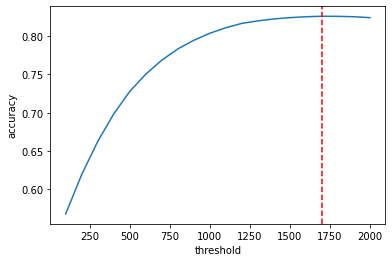

In [16]:
index_max_element = accuracies.index(max(accuracies))
plt.plot(thresholds, accuracies)
plt.axvline(x=thresholds[index_max_element], c = 'r', ls="--")
plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.show()

The best accuracy is for threshold 1700.

In [12]:
best_threshold = 1700
print(max(accuracies))

0.8257841391590193


### Test evaluation for best threshold

In [11]:
best_threshold = 1700

In [8]:
best_laplacian = MotionBlurDetectionLaplacian(threshold=1700., images_regions=regions_test)
test_predictions = best_laplacian.predict()

In [9]:
test_predicted_labels = [pred for pred, fm in test_predictions]
test_fms = [fm for pred, fm in test_predictions]

In [14]:
show_scores(test_ground_truth_labels, test_predicted_labels, 'Laplacian')


    Laplacian metrics:
          Accuracy: 	0.82484591151897
          Precision: 	0.7736587612249597
          Recall: 	0.91908747743312
          F1 score: 	0.8401260189028354
          


The accuracy is close to the one achieved on train set thus the threshold is truly the best one.

### Test results visualisations

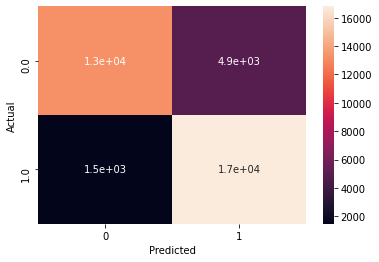

In [15]:
confusion_matrix(test_ground_truth_labels, test_predicted_labels)

The algorithm is more often wrong when it answers that the image is blurry when it is not thus the precision is lower. 

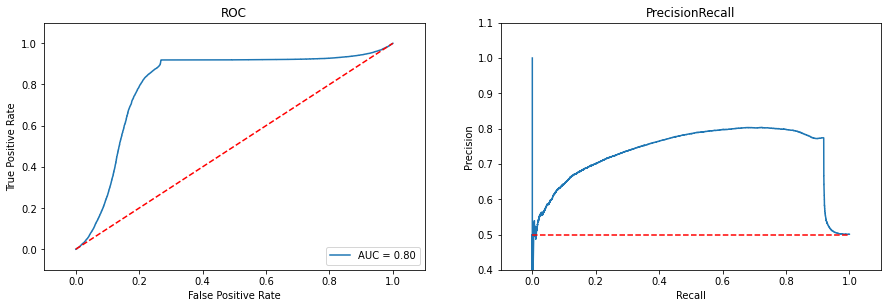

In [13]:
probabilities = []
differences = [abs(fm-best_threshold) for fm in test_fms]
max_diff = max(differences)
for i in range(len(differences)):
    predicted_class_probability = 1*differences[i]/max_diff
    if test_predicted_labels[i] == 0:
        probability = [1-predicted_class_probability,
                       predicted_class_probability]
    else:
        probability = [predicted_class_probability, 
                       1-predicted_class_probability]
    probabilities.append(probability)
probabilities = np.array(probabilities)
roc_pr_rec_plots(test_ground_truth_labels, test_predicted_labels, probabilities)

### Sample image blur detection result for best threshold

In [20]:
def image_mask(image_path, threshold=1700.):
    laplacian = MotionBlurDetectionLaplacian(threshold=threshold, images_regions=[])
    image_predictions_fm = laplacian.predict_single_image(image_path)
    image_predictions = []
    for i in range(4,len(image_predictions_fm)+1, 5):
        row = [pred for pred, fm in image_predictions_fm[i-4:i+1]]
        image_predictions.append(row)
    image_mask = mask_on_image(image_path, image_predictions)
    return image_mask

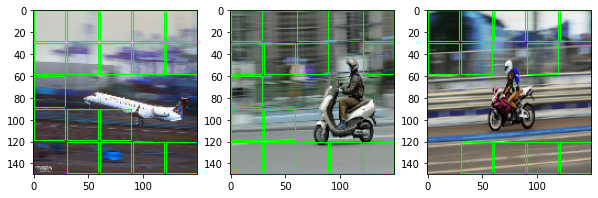

In [21]:
images_paths = ['./data/real/plane.jpg', './data/real/scooter.jpg', './data/real/motorcycle.png']
masked_images = []
for image_path in images_paths:
    mask = image_mask(image_path)
    masked_images.append(mask)
    
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,3,1)
ax1.imshow(masked_images[0])
ax2 = fig.add_subplot(2,3,2)
ax2.imshow(masked_images[1])
ax3 = fig.add_subplot(2,3,3)
ax3.imshow(masked_images[2])

plt.show()

## Nao dataset evaluation

In [20]:
eval_regions = get_evalutaion_img_regions()

In [21]:
eval_regions = random.sample(eval_regions, 10000)

In [22]:
eval_ground_truth_labels = [eval_region.label for eval_region in eval_regions]

In [23]:
eval_laplacian = MotionBlurDetectionLaplacian(threshold=1700., images_regions=eval_regions)
eval_predictions = eval_laplacian.predict()

In [24]:
eval_predicted_labels = [pred for pred, fm in eval_predictions]
eval_fms = [fm for pred, fm in eval_predictions]

In [25]:
show_scores(eval_ground_truth_labels, eval_predicted_labels, 'Laplacian')


    Laplacian metrics:
          Accuracy: 	0.7427
          Precision: 	0.7931769722814499
          Recall: 	0.8900704506181045
          F1 score: 	0.8388349514563107
          


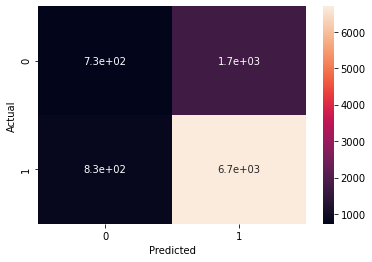

In [26]:
confusion_matrix(eval_ground_truth_labels, eval_predicted_labels)

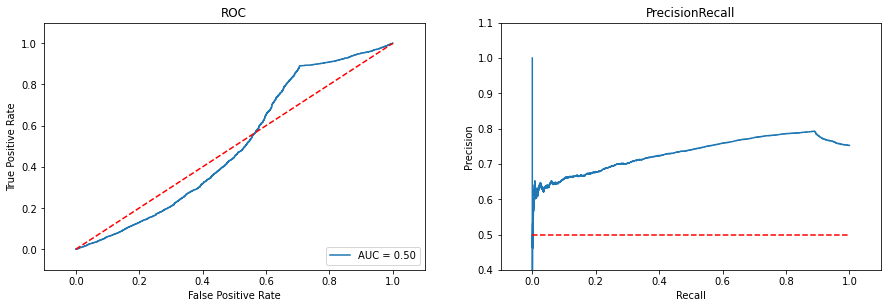

In [27]:
probabilities = []
differences = [abs(fm-1700.) for fm in eval_fms]
max_diff = max(differences)
for i in range(len(differences)):
    predicted_class_probability = 1*differences[i]/max_diff
    if eval_predicted_labels[i] == 0:
        probability = [1-predicted_class_probability,
                       predicted_class_probability]
    else:
        probability = [predicted_class_probability, 
                       1-predicted_class_probability]
    probabilities.append(probability)
probabilities = np.array(probabilities)
roc_pr_rec_plots(eval_ground_truth_labels, eval_predicted_labels, probabilities)